# Linear regression

## Contents in this notebook:
1. [Notebook setup](#setup)
2. [Univariate linear regression](#linreg1)
3. [Multiple linear regression](#linregmult)
4. [Response scaling against heteroscedasticity](#heterosced)
5. [Multicollinearity](#muticoll)
6. [Polynomial features](#poly)

## 1. Notebook setup <a name="setup"></a>

In [1]:
# Install required packages.
# !pip install requirements.txt

# Change directory to main project folder.
import os
print(f'This folder: {os.getcwd()}')
os.chdir("..")
print(f'Project folder: {os.getcwd()}\n')

# Import packages.
import routing
import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle

import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold, ParameterGrid, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso

This folder: C:\Users\muell\thesis_main\thesis_code\notebooks - GitHub
Project folder: C:\Users\muell\thesis_main\thesis_code



In [2]:
# Load training data

X_train = pd.read_pickle('data/generated_final_pickle/df_features_train.pickle')
y_train = X_train.pop('distance')
print(X_train.shape, y_train.shape)

(80000, 43) (80000,)


In [3]:
# create dict for results comparison
results = {}

## 2. Univariate linear regression <a name="linreg1"></a>

In [4]:
# Which feature correlates most with distance
abs(X_train.corrwith(y_train)).sort_values(ascending=False)[:1]

NumVehMin    0.603908
dtype: float64

In [5]:
# Use statsmodels to plot regression table

X_train_univariate = X_train.loc[:,'NumVehMin']
#X_train_univariate = sm.add_constant(X_train_univariate)
est = sm.OLS(y_train, X_train_univariate)
est = est.fit()
print(est.summary(title='Univariate regression', alpha=0.05, slim=True))

                            Univariate regression                             
Dep. Variable:               distance   F-statistic:                 1.317e+05
Model:                            OLS   Prob (F-statistic):               0.00
No. Observations:               80000                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NumVehMin   1087.0569      2.996    362.884      0.000    1081.186    1092.928

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.



reg.intercept_ = 0.0
reg.coef_ = [1087.05694601]
RMSE (mean, std): 5846.199 (28.203)


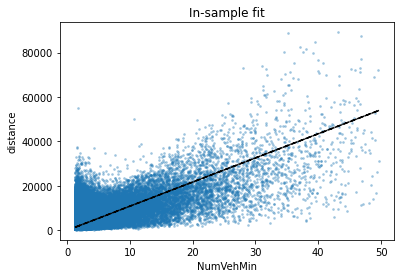

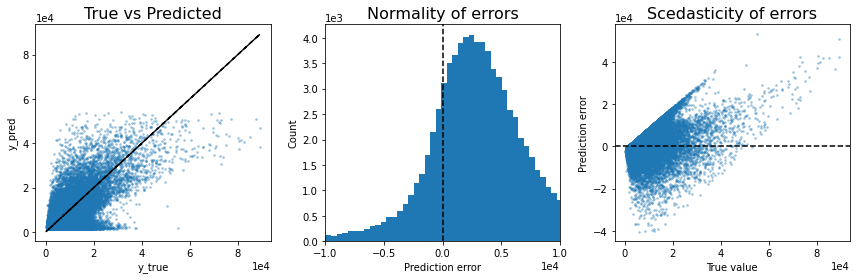

LinearRegression(fit_intercept=False)

In [6]:
# Use sklearn for further modelling and analysis

# get feature
X_train_univariate = np.array(X_train['NumVehMin']).reshape(-1, 1)

# fit the model
reg_univariate = LinearRegression(fit_intercept=False) # no intercept since an empty instance should have a predicted distance of 0
reg_univariate.fit(X_train_univariate, y_train)

# print coefficients
print('\nreg.intercept_ =', reg_univariate.intercept_)
print('reg.coef_ =', reg_univariate.coef_)

# evaluate model
scores = abs(cross_val_score(
    reg_univariate, X_train_univariate, y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=KFold(n_splits=5), verbose=0, n_jobs=5))
print(f'RMSE (mean, std): %.3f (%.3f)' % (scores.mean(), scores.std()))

# store result
results['reg_univariate'] = [scores.mean(), scores.std()]

# compute in-sample residuals
y_pred = reg_univariate.predict(X_train_univariate)
residuals = y_train - y_pred

# plot in-sample fit
plt.title('In-sample fit')
plt.scatter(X_train_univariate, y_train, s=3, alpha=0.3)
plt.plot(X_train_univariate, reg_univariate.coef_*X_train_univariate + 0, color='k', linestyle='--')
plt.xlabel('NumVehMin')
plt.ylabel('distance')
plt.show()
print()

# plot residual plots
models.plot_performance(y_train, y_pred)

# save model
reg_univariate.fit(X_train_univariate, y_train)
# with open('models/linear_univariate.pkl', 'wb') as f:
#     pickle.dump(reg_univariate, f)

## 3. Multiple linear regression <a name="linregmult"></a>

In [7]:
# Use statsmodels to plot regression table

#X_train = sm.add_constant(X_train)
est = sm.OLS(y_train, X_train)
est = est.fit()
print(est.summary(title='Multiple regression', alpha=0.05, slim=True))

                             Multiple regression                              
Dep. Variable:               distance   F-statistic:                 3.002e+04
Model:                            OLS   Prob (F-statistic):               0.00
No. Observations:               80000                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
NumCust         63.9033      0.763     83.710      0.000      62.407      65.400
AreaRoot         6.6757      0.500     13.355      0.000       5.696       7.655
Perimeter        1.8978      0.125     15.184      0.000       1.653       2.143
SideRatio      295.5053     32.467      9.102      0.000     231.870     359.141
CentDepot     1247.2085    176.501      7.066      0.000     901.268    1593.149
CentCustAvg   7988.0970   1271.270    

RMSE (mean, std): 2299.381 (24.379)


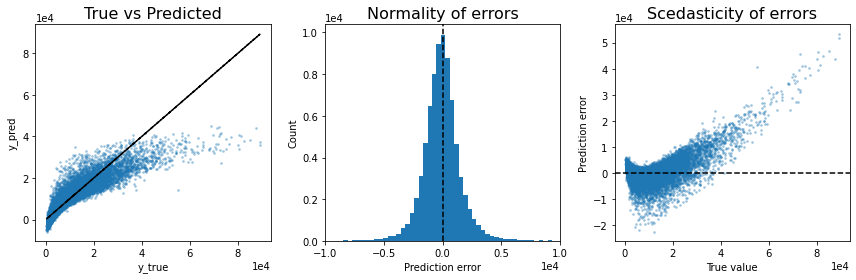

LinearRegression(fit_intercept=False)

In [8]:
# Use sklearn for further modelling and analysis

# fit the model
reg_multiple = LinearRegression(fit_intercept=False) # no intercept since an empty instance should have a predicted distance of 0
reg_multiple.fit(X_train, y_train)

# # print coefficients
# print('\nreg.intercept_ =', reg_univariate.intercept_)
# print('reg.coef_ =', reg_univariate.coef_)

# evaluate model
scores_linreg = abs(cross_val_score(
    reg_multiple, X_train, y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=KFold(n_splits=5), verbose=0, n_jobs=5))
print(f'RMSE (mean, std): %.3f (%.3f)' % (scores_linreg.mean(), scores_linreg.std()))

# store result
results['reg_multiple'] = [scores_linreg.mean(), scores_linreg.std()]

# plot residual plots
y_pred = reg_multiple.predict(X_train)
models.plot_performance(y_train, y_pred)

# save model
reg_multiple.fit(X_train, y_train)
# with open('models/linear_multiple.pkl', 'wb') as f:
#     pickle.dump(reg_multiple, f)

-3.528364140602029


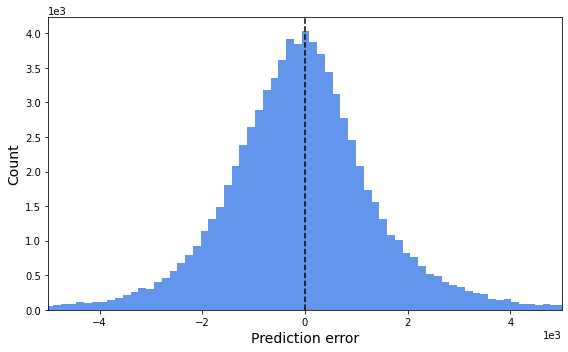

In [9]:
# assumption: errors have a mean of 0

residuals = y_train - y_pred
print(np.mean(residuals))

fig, axs = plt.subplots(1, 1, figsize=(8,5))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs.hist(residuals, bins=500, color = "cornflowerblue")
axs.set_xlim((-5000,5000))
axs.set_xlabel('Prediction error', fontsize=14)
axs.set_ylabel('Count', fontsize=14)
axs.axvline(x=0.0, color='k', linestyle='--')
axs.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
fig.tight_layout()
#plt.savefig('reg_error_distribution.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
#plt.savefig('reg_error_distribution.jpg', pad_inches=0.4)#bbox_inches='tight')
plt.show()

## 4. Response scaling against heteroscedasticity <a name="heterosced"></a>

In [10]:
# y transforms
def identity(y):
    return y
def log_transform(y):
    return np.log(y)
def exp_transform(y):
    return np.exp(y)
def sqrt_transform(y):
    return np.sqrt(y)
def squared_transform(y):
    return y ** 2

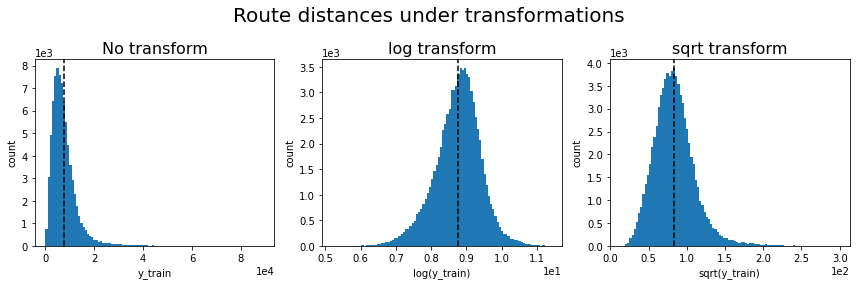

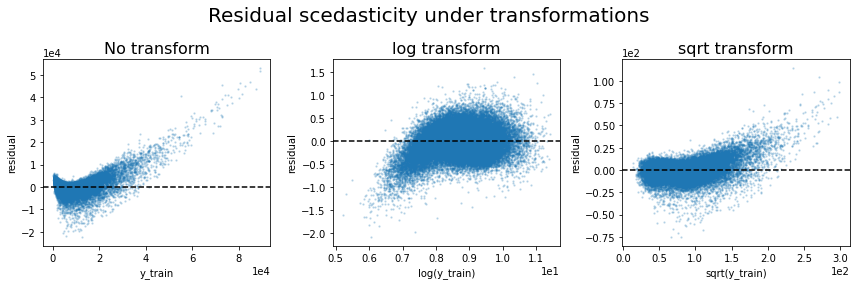

In [11]:
# plot y transform comparison

fig, axs = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('Route distances under transformations', fontsize=20)

# No transform
axs[0].set_title('No transform', fontsize=16)
axs[0].hist(y_train, bins=100)
axs[0].axvline(x=np.mean(y_train), color='k', linestyle='--')
axs[0].set(xlabel='y_train', ylabel='count')
axs[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

# log transform
axs[1].set_title('log transform', fontsize=16)
axs[1].hist(np.log(y_train), bins=100)
axs[1].axvline(x=np.mean(np.log(y_train)), color='k', linestyle='--')
axs[1].set(xlabel='log(y_train)', ylabel='count')
axs[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

# sqrt transform
axs[2].set_title('sqrt transform', fontsize=16)
axs[2].hist(np.sqrt(y_train), bins=100)
axs[2].axvline(x=np.mean(np.sqrt(y_train)), color='k', linestyle='--')
axs[2].set(xlabel='sqrt(y_train)', ylabel='count')
axs[2].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

plt.tight_layout()
plt.show()



# plot scedasticity comparison

reg_multiple = LinearRegression(fit_intercept=False)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
plt.suptitle('Residual scedasticity under transformations', fontsize=20)

# No transform
reg_multiple.fit(X_train, y_train)
y_pred = reg_multiple.predict(X_train)
residuals = y_train - y_pred
axs[0].set_title('No transform', fontsize=16)
axs[0].scatter(y_train, residuals, s=2, alpha=0.2)
axs[0].axhline(y=0.0, color='k', linestyle='--')
axs[0].set(xlabel='y_train', ylabel='residual')
axs[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

# log transform
y_train_log = log_transform(y_train)
reg_multiple.fit(X_train, y_train_log)
y_pred = reg_multiple.predict(X_train)
residuals = y_train_log - y_pred
axs[1].set_title('log transform', fontsize=16)
axs[1].scatter(y_train_log, residuals, s=2, alpha=0.2)
axs[1].axhline(y=0.0, color='k', linestyle='--')
axs[1].set(xlabel='log(y_train)', ylabel='residual')
axs[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

# sqrt transform
y_train_sqrt = sqrt_transform(y_train)
reg_multiple.fit(X_train, y_train_sqrt)
y_pred = reg_multiple.predict(X_train)
residuals = y_train_sqrt - y_pred
axs[2].set_title('sqrt transform', fontsize=16)
axs[2].scatter(y_train_sqrt, residuals, s=2, alpha=0.2)
axs[2].axhline(y=0.0, color='k', linestyle='--')
axs[2].set(xlabel='sqrt(y_train)', ylabel='residual')
axs[2].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

plt.tight_layout()
plt.show()

No transform: RMSE (mean, std): 2299.381 (24.379)


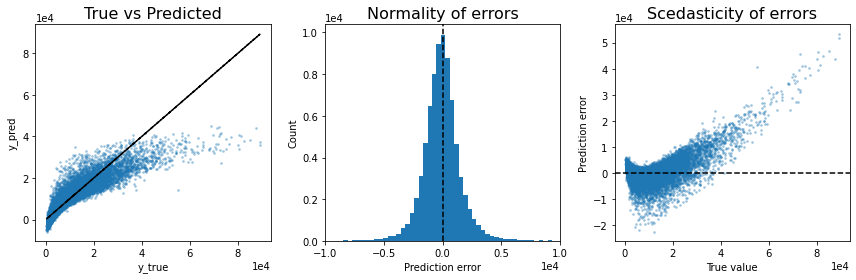

Log transform: RMSE (mean, std): 2753.733 (74.316)


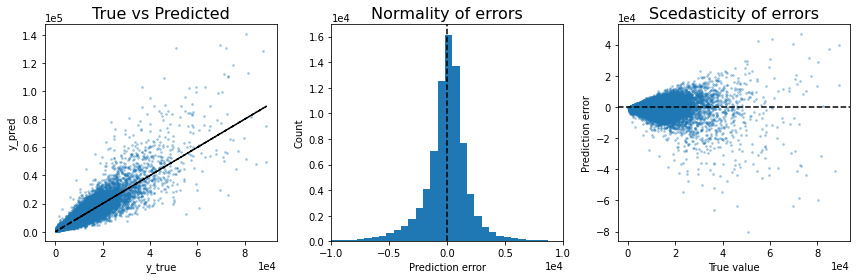

Sqrt transform: RMSE (mean, std): 1877.693 (36.130)


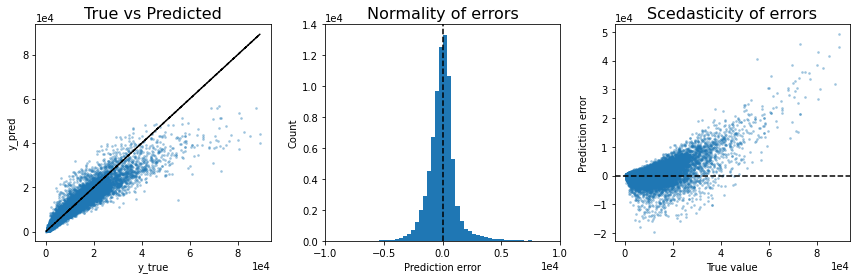

In [12]:
# create and evaluate identity model
reg_multiple = TransformedTargetRegressor(
    regressor=LinearRegression(fit_intercept=False), 
    func=identity, 
    inverse_func=identity, 
    check_inverse=False)
scores_identity = abs(cross_val_score(
    reg_multiple, X_train, y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=KFold(n_splits=5), verbose=0, n_jobs=5))
print(f'No transform: RMSE (mean, std): %.3f (%.3f)' % (scores_identity.mean(), scores_identity.std()))
results['reg_multiple'] = [scores_identity.mean(), scores_identity.std()]
reg_multiple.fit(X_train, y_train)
y_pred = reg_multiple.predict(X_train)
models.plot_performance(y_train, y_pred)

# create and evaluate log model
reg_log = TransformedTargetRegressor(
    regressor=LinearRegression(fit_intercept=False), 
    func=log_transform, 
    inverse_func=exp_transform, 
    check_inverse=False)
scores_log = abs(cross_val_score(
    reg_log, X_train, y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=KFold(n_splits=5), verbose=0, n_jobs=5))
print(f'Log transform: RMSE (mean, std): %.3f (%.3f)' % (scores_log.mean(), scores_log.std()))
results['reg_multiple_log'] = [scores_log.mean(), scores_log.std()]
reg_log.fit(X_train, y_train)
y_pred = reg_log.predict(X_train)
models.plot_performance(y_train, y_pred)

# create and evaluate sqrt model
reg_sqrt = TransformedTargetRegressor(
    regressor=LinearRegression(fit_intercept=False), 
    func=sqrt_transform, 
    inverse_func=squared_transform, 
    check_inverse=False)
scores_sqrt = abs(cross_val_score(
    reg_sqrt, X_train, y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=KFold(n_splits=5), verbose=0, n_jobs=5))
print(f'Sqrt transform: RMSE (mean, std): %.3f (%.3f)' % (scores_sqrt.mean(), scores_sqrt.std()))
results['reg_multiple_sqrt'] = [scores_sqrt.mean(), scores_sqrt.std()]
reg_sqrt.fit(X_train, y_train)
y_pred = reg_sqrt.predict(X_train)
models.plot_performance(y_train, y_pred)

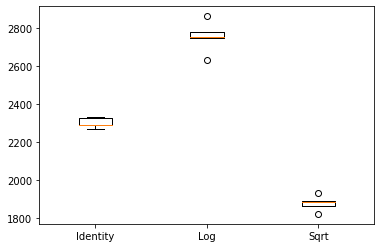

In [13]:
plt.boxplot([scores_identity, scores_log, scores_sqrt], labels=['Identity', 'Log', 'Sqrt'])
plt.show()

In [14]:
pd.DataFrame(results, index=['mean(RMSE)', 'std(RMSE)']).T.sort_values('mean(RMSE)')

,mean(RMSE),std(RMSE)
reg_multiple_sqrt,1877.692696,36.130172
reg_multiple,2299.381176,24.379494
reg_multiple_log,2753.733010,74.316132
reg_univariate,5846.198590,28.203341


In [15]:
# save sqrt model
reg_sqrt = TransformedTargetRegressor(
    regressor=LinearRegression(fit_intercept=False), 
    func=sqrt_transform, 
    inverse_func=squared_transform, 
    check_inverse=False)
reg_sqrt.fit(X_train, y_train)
# with open('models/linear_multiple_root.pkl', 'wb') as f:
#     pickle.dump(reg_sqrt, f)

TransformedTargetRegressor(check_inverse=False,
                           func=<function sqrt_transform at 0x00000136DBFCC430>,
                           inverse_func=<function squared_transform at 0x00000136DBFCC4C0>,
                           regressor=LinearRegression(fit_intercept=False))

## 5. Multicollinearity <a name="multicoll"></a>

<AxesSubplot:>

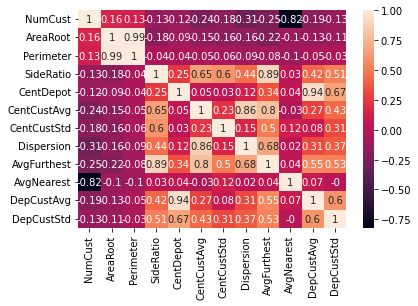

In [16]:
# Correlation matrix

correlation_matrix = X_train.iloc[:,:12].corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [17]:
# Identify highly correlated features

d = {X_train.columns[i]: 0 for i in range(len(X_train.columns))}

for i in range(len(X_train.columns)):
    for j in range(i+1, len(X_train.columns)):
        corr = np.corrcoef(X_train.iloc[:,i], X_train.iloc[:,j])[0][1]
        if abs(corr) > 0.9:
            print(X_train.columns[i], X_train.columns[j], round(corr, 4))
            d[X_train.columns[i]] += 1
            d[X_train.columns[j]] += 1
#d

AreaRoot Perimeter 0.9856
CentDepot DepCustAvg 0.9377
CentDepot DepCustMax 0.9172
CentCustAvg IntCustAvg 0.9805
CentCustAvg IntCustStd 0.9346
DepCustAvg DepCustMed 0.9625
IntCustLinks TwWidthAvg 0.9479
IntCustAvg IntCustStd 0.9114
DemAvg DemMed 0.978
DemStd DemMax 0.9303
StAvg StMed 0.9926


In [18]:
# Drop highly correlated features

# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
#to_drop

# Drop features 
X_train_nocorr = X_train.drop(to_drop, axis=1)

In [19]:
# Identify highly correlated features

d = {X_train_nocorr.columns[i]: 0 for i in range(len(X_train_nocorr.columns))}

for i in range(len(X_train_nocorr.columns)):
    for j in range(i+1, len(X_train_nocorr.columns)):
        corr = np.corrcoef(X_train_nocorr.iloc[:,i], X_train_nocorr.iloc[:,j])[0][1]
        if abs(corr) > 0.6:
            print(X_train_nocorr.columns[i], X_train_nocorr.columns[j], round(corr, 4))
            d[X_train_nocorr.columns[i]] += 1
            d[X_train_nocorr.columns[j]] += 1
#d

In [20]:
# drop/select (directly)

X_train_nocorr = X_train[[
    'NumCust', 'AreaRoot', 'DepCustAvg', 'CapRatio', 'DemAvg', 
    'StAvg', 'TwShare', 'TwWidthAvg']]#'PossRounds', 

In [21]:
X_train_nocorr.shape

(80000, 8)

In [23]:
# Use statsmodels to plot regression table

#X_train = sm.add_constant(X_train)
est = sm.OLS(y_train, X_train_nocorr)
est = est.fit()
print(est.summary(title='Multiple regression', alpha=0.05, slim=True))

                             Multiple regression                              
Dep. Variable:               distance   F-statistic:                 1.001e+05
Model:                            OLS   Prob (F-statistic):               0.00
No. Observations:               80000                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NumCust       95.4115      0.461    206.945      0.000      94.508      96.315
AreaRoot      13.7402      0.049    282.598      0.000      13.645      13.835
DepCustAvg  4320.5059     39.874    108.355      0.000    4242.354    4398.658
CapRatio     231.3798     57.341      4.035      0.000     118.992     343.768
DemAvg      2.803e+04    122.646    228.557      0.000    2.78e+04    2.83e+04
StAvg       2.375e+04    433.121     54.837      0.0

## 6. Polynomial features <a name="poly"></a>

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   27.9s remaining:   41.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.9s finished


RMSE (mean, std): 815.446 (51.528)


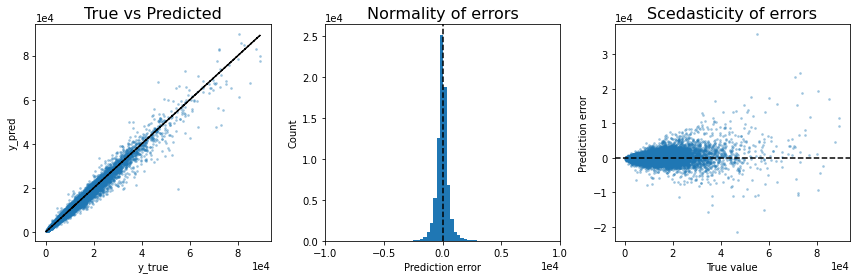

In [24]:
# add polynomial features
regr = TransformedTargetRegressor(
    regressor=Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), 
        ('reg', LinearRegression(fit_intercept=False))
    ]), 
    func=lambda y: np.sqrt(y), 
    inverse_func=lambda y: y**2, 
    check_inverse=False)

# evaluation
scores_polynomial = abs(cross_val_score(
    regr, X_train, y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=KFold(n_splits=5), verbose=2, n_jobs=5))
print(f'RMSE (mean, std): %.3f (%.3f)' % (scores_polynomial.mean(), scores_polynomial.std()))
    
# store result
results['reg_polynomial'] = [scores_polynomial.mean(), scores_polynomial.std()]

# plot residual plots
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
models.plot_performance(y_train, y_pred)

# save model
regr.fit(X_train, y_train)
# with open('models/linear_polynomial.pkl', 'wb') as f:
#     pickle.dump(regr, f)

In [25]:
pd.DataFrame(results, index=['mean(RMSE)', 'std(RMSE)']).T.sort_values('mean(RMSE)')

,mean(RMSE),std(RMSE)
reg_polynomial,815.445707,51.528040
reg_multiple_sqrt,1877.692696,36.130172
reg_multiple,2299.381176,24.379494
reg_multiple_log,2753.733010,74.316132
reg_univariate,5846.198590,28.203341


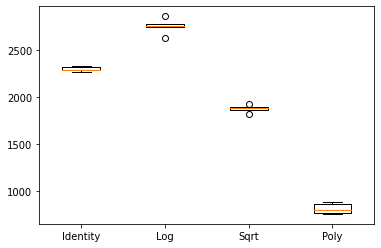

In [26]:
plt.boxplot([scores_identity, scores_log, scores_sqrt, scores_polynomial], labels=['Identity', 'Log', 'Sqrt', 'Poly'])
plt.show()

In [13]:
# When performing regularization, it is important to scale the features
sc = StandardScaler() # performs bad without intercept, use MinMaxScaler() instead

In [5]:
# add polynomial features
# loop over several values for alpha-tuning
for alpha in range(1, 19, 3): 
    
    regr = TransformedTargetRegressor(
    regressor=Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), 
        ('scaler', MinMaxScaler()), 
        ('reg', Lasso(alpha=alpha/10, fit_intercept=False, max_iter=10000, tol=0.001 ))
    ]), 
    func=lambda y: np.sqrt(y), 
    inverse_func=lambda y: y**2, 
    check_inverse=False)

    # evaluation
    scores = abs(cross_val_score(
        regr, X_train, y_train, 
        scoring='neg_root_mean_squared_error', 
        cv=KFold(n_splits=5), verbose=2, n_jobs=5))
    print(f'{alpha} - RMSE (mean, std): %.3f (%.3f)' % (scores.mean(), scores.std()))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   32.7s remaining:   49.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   33.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


1 - RMSE (mean, std): 1512.596 (67.824)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   22.5s remaining:   33.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   23.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


4 - RMSE (mean, std): 2530.991 (127.467)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.1s remaining:   15.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


7 - RMSE (mean, std): 2966.306 (147.166)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


10 - RMSE (mean, std): 3421.018 (158.544)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


13 - RMSE (mean, std): 3866.664 (152.477)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.3s


16 - RMSE (mean, std): 4051.121 (155.521)


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.1s finished


In [ ]:
# save model
regr.fit(X_train, y_train)
with open('models/linear_lasso.pkl', 'wb') as f:
    pickle.dump(regr, f)

In [5]:
### LINEAR REGRESSION

# define parameter grid
name = 'LinearRegression'
param_grid = {
    'intercept': [True, False], 
    'input_scaling': ['none', 'minmax', 'standard'], 
    'y_transform': ['none', 'log', 'sqrt']
}

# loop through parameter combinations
for params in list(ParameterGrid(param_grid)):
    
    # define model specification from params
    reg = LinearRegression(fit_intercept=params['intercept'])
    if params['input_scaling'] == 'none':
        pipe = Pipeline([('reg', reg)])
    elif params['input_scaling'] == 'minmax':
        pipe = Pipeline([('scaler', MinMaxScaler()), ('reg', reg)])
    elif params['input_scaling'] == 'standard':
        pipe = Pipeline([('scaler', StandardScaler()), ('reg', reg)])
    if params['y_transform'] == 'none':
        y_transform = identity
        inverse_y_transform = identity
    elif params['y_transform'] == 'log':
        y_transform = log_transform
        inverse_y_transform = exp_transform
    elif params['y_transform'] == 'sqrt':
        y_transform = sqrt_transform
        inverse_y_transform = squared_transform
    
    # create model
    regr = TransformedTargetRegressor(
        regressor=pipe, 
        func=y_transform, 
        inverse_func=inverse_y_transform, 
        check_inverse=False)
    
    # evaluate model
    scores = abs(cross_val_score(
        regr, X_train, y_train, 
        scoring='neg_root_mean_squared_error', 
        cv=KFold(n_splits=5), verbose=0, n_jobs=5))
    print(f'params = {params} | RMSE (mean, std): %.3f (%.3f)' % (scores.mean(), scores.std()))
    
    # store result
    model_name = name+'_'+str(params['intercept'])+'_'+params['input_scaling']+'_'+params['y_transform']
    results[model_name] = [scores.mean(), scores.std()]

params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'none'} | RMSE (mean, std): 2294.780 (24.270)
params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'log'} | RMSE (mean, std): 2006.943 (61.282)
params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'sqrt'} | RMSE (mean, std): 1877.013 (35.483)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'none'} | RMSE (mean, std): 2299.381 (24.379)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'log'} | RMSE (mean, std): 2753.733 (74.316)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'sqrt'} | RMSE (mean, std): 1877.693 (36.130)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'none'} | RMSE (mean, std): 2294.780 (24.270)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'log'} | RMSE (mean, std): 2006.943 (61.282)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'sqrt

In [6]:
pd.DataFrame(results, index=['mean(RMSE)', 'std(RMSE)']).T.sort_values('mean(RMSE)')

,mean(RMSE),std(RMSE)
LinearRegression_False_minmax_sqrt,1876.517673,36.083835
LinearRegression_True_none_sqrt,1877.013468,35.482531
LinearRegression_True_minmax_sqrt,1877.013468,35.482531
LinearRegression_True_standard_sqrt,1877.013468,35.482531
LinearRegression_False_none_sqrt,1877.692696,36.130172
LinearRegression_True_none_log,2006.942568,61.281732
LinearRegression_True_standard_log,2006.942568,61.281732
LinearRegression_True_minmax_log,2006.942568,61.281732
LinearRegression_True_none_none,2294.780285,24.269709
LinearRegression_True_minmax_none,2294.780285,24.269709


In [ ]:
# STATSMODELS

minmax_scaler = MinMaxScaler().fit(X_train)
X_train_sm = minmax_scaler.transform(X_train)
#X_train_sm = pd.DataFrame(X_train_sm)
#X_train_sm = sm.add_constant(X_train_sm)
y_train_sm = np.sqrt(y_train)

reg = sm.OLS(y_train_sm, X_train_sm)
reg = reg.fit()
print(reg.summary(title='Multiple regression', alpha=0.05, slim=False))

                                  Multiple regression                                  
Dep. Variable:               distance   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          2.466e+05
Date:                Tue, 01 Mar 2022   Prob (F-statistic):                        0.00
Time:                        09:28:42   Log-Likelihood:                     -2.7586e+05
No. Observations:               80000   AIC:                                  5.518e+05
Df Residuals:                   79957   BIC:                                  5.522e+05
Df Model:                          43                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
### RIDGE REGRESSION

# define parameter grid
name = 'RidgeRegression'
param_grid = {
    'intercept': [True, False], 
    'input_scaling': ['none', 'minmax', 'standard'], 
    'y_transform': ['none', 'log', 'sqrt']
}

# loop through parameter combinations
for params in list(ParameterGrid(param_grid)):
    
    # define model specification from params
    reg = Ridge(fit_intercept=params['intercept'])
    if params['input_scaling'] == 'none':
        pipe = Pipeline([('reg', reg)])
    elif params['input_scaling'] == 'minmax':
        pipe = Pipeline([('scaler', MinMaxScaler()), ('reg', reg)])
    elif params['input_scaling'] == 'standard':
        pipe = Pipeline([('scaler', StandardScaler()), ('reg', reg)])
    if params['y_transform'] == 'none':
        y_transform = identity
        inverse_y_transform = identity
    elif params['y_transform'] == 'log':
        y_transform = log_transform
        inverse_y_transform = exp_transform
    elif params['y_transform'] == 'sqrt':
        y_transform = sqrt_transform
        inverse_y_transform = squared_transform
    
    # create model
    regr = TransformedTargetRegressor(
        regressor=pipe, 
        func=y_transform, 
        inverse_func=inverse_y_transform, 
        check_inverse=False)
    
    # evaluate model
    scores = abs(cross_val_score(
        regr, X_train, y_train, 
        scoring='neg_root_mean_squared_error', 
        cv=KFold(n_splits=5), verbose=0, n_jobs=5))
    print(f'params = {params} | RMSE (mean, std): %.3f (%.3f)' % (scores.mean(), scores.std()))
    
    # store result
    model_name = name+'_'+str(params['intercept'])+'_'+params['input_scaling']+'_'+params['y_transform']
    results[model_name] = [scores.mean(), scores.std()]   

params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'none'} | RMSE (mean, std): 2295.003 (24.151)
params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'log'} | RMSE (mean, std): 2008.676 (61.438)
params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'sqrt'} | RMSE (mean, std): 1878.478 (35.107)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'none'} | RMSE (mean, std): 2299.518 (24.279)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'log'} | RMSE (mean, std): 2762.380 (75.695)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'sqrt'} | RMSE (mean, std): 1879.194 (35.771)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'none'} | RMSE (mean, std): 2295.318 (24.290)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'log'} | RMSE (mean, std): 2006.056 (61.559)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'sqrt

In [ ]:
### LASSO REGRESSION

# define parameter grid
name = 'LassoRegression'
param_grid = {
    'intercept': [True, False], 
    'input_scaling': ['none', 'minmax', 'standard'], 
    'y_transform': ['none', 'log', 'sqrt']
}

# loop through parameter combinations
for params in list(ParameterGrid(param_grid)):
    
    # define model specification from params
    reg = Lasso(fit_intercept=params['intercept'])
    if params['input_scaling'] == 'none':
        pipe = Pipeline([('reg', reg)])
    elif params['input_scaling'] == 'minmax':
        pipe = Pipeline([('scaler', MinMaxScaler()), ('reg', reg)])
    elif params['input_scaling'] == 'standard':
        pipe = Pipeline([('scaler', StandardScaler()), ('reg', reg)])
    if params['y_transform'] == 'none':
        y_transform = identity
        inverse_y_transform = identity
    elif params['y_transform'] == 'log':
        y_transform = log_transform
        inverse_y_transform = exp_transform
    elif params['y_transform'] == 'sqrt':
        y_transform = sqrt_transform
        inverse_y_transform = squared_transform
    
    # create model
    regr = TransformedTargetRegressor(
        regressor=pipe, 
        func=y_transform, 
        inverse_func=inverse_y_transform, 
        check_inverse=False)
    
    # evaluate model
    scores = abs(cross_val_score(
        regr, X_train, y_train, 
        scoring='neg_root_mean_squared_error', 
        cv=KFold(n_splits=5), verbose=0, n_jobs=5))
    print(f'params = {params} | RMSE (mean, std): %.3f (%.3f)' % (scores.mean(), scores.std()))
    
    # store result
    model_name = name+'_'+str(params['intercept'])+'_'+params['input_scaling']+'_'+params['y_transform']
    results[model_name] = [scores.mean(), scores.std()]

params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'none'} | RMSE (mean, std): 2299.738 (24.306)
params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'log'} | RMSE (mean, std): 3922.768 (46.828)
params = {'input_scaling': 'none', 'intercept': True, 'y_transform': 'sqrt'} | RMSE (mean, std): 2500.804 (26.713)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'none'} | RMSE (mean, std): 2308.503 (25.125)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'log'} | RMSE (mean, std): 105881.322 (9277.473)
params = {'input_scaling': 'none', 'intercept': False, 'y_transform': 'sqrt'} | RMSE (mean, std): 2481.951 (26.869)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'none'} | RMSE (mean, std): 2302.537 (24.572)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': 'log'} | RMSE (mean, std): 5707.006 (40.399)
params = {'input_scaling': 'minmax', 'intercept': True, 'y_transform': '

In [ ]:
pd.DataFrame(results, index=['mean(RMSE)', 'std(RMSE)']).T.sort_values('mean(RMSE)')

,mean(RMSE),std(RMSE)
LinearRegression_False_minmax_sqrt,1876.517673,36.083835
LinearRegression_True_none_sqrt,1877.013468,35.482531
LinearRegression_True_minmax_sqrt,1877.013468,35.482531
LinearRegression_True_standard_sqrt,1877.013468,35.482531
RidgeRegression_True_standard_sqrt,1877.039770,35.476022
LinearRegression_False_none_sqrt,1877.692696,36.130172
RidgeRegression_True_none_sqrt,1878.477902,35.106632
RidgeRegression_False_none_sqrt,1879.194259,35.770992
RidgeRegression_False_minmax_sqrt,1880.172873,35.846162
RidgeRegression_True_minmax_sqrt,1880.668783,35.211949


In [3]:
# save best model

regr = TransformedTargetRegressor(
    regressor=Pipeline([
        ('scaler', MinMaxScaler()), 
        ('reg', LinearRegression(fit_intercept=False))
    ]), 
    func=lambda y: np.sqrt(y), 
    inverse_func=lambda y: y**2, 
    check_inverse=False)
regr.fit(X_train, y_train)

with open('models/linear_best.pkl', 'wb') as f:
    pickle.dump(regr, f)